## This script performs an analysis of the 4 documents---.csv files in the data 

#### These files contain information about the content of the web page on display and the goal is to extract critical features for the webpages

In [1]:
# Importing the libraries
import os
from matplotlib import pyplot as plt
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import *
import numpy as np
from pyspark.sql import SQLContext
from pyspark import SparkContext

### 1) File paths:

In [2]:
docCat = "gs://jupyterbucket/outbrainData/documents_categories.csv"
docEnt = "gs://jupyterbucket/outbrainData/documents_entities.csv"
docMet = "gs://jupyterbucket/outbrainData/documents_meta.csv"
docTop = "gs://jupyterbucket/outbrainData/documents_topics.csv"

In [3]:
def csvOverview(fpath):
    '''
    Function presents a basic overview of the file fed in the argument
    @params
    fpath: Path to the csv file that needs to be analyzed
    @returns 
    None
    '''
    # Reading the data as a spark dataframe
    print fpath.split("/")[-1]
    fpathDF = spark.read.options(header='true', inferschema='true', nullValue='\\N') \
                .csv(fpath)
    print "Dataframe has ", fpathDF.count(), " rows."
    fpathDF.show(n=5)
    
    return None

### 2) Analysis for each file:

#### a) documents_meta.csv

In [4]:
csvOverview(docMet)

documents_meta.csv
Dataframe has  2999334  rows.
+-----------+---------+------------+--------------------+
|document_id|source_id|publisher_id|        publish_time|
+-----------+---------+------------+--------------------+
|    1595802|        1|         603|2016-06-05 00:00:...|
|    1524246|        1|         603|2016-05-26 11:00:...|
|    1617787|        1|         603|2016-05-27 00:00:...|
|    1615583|        1|         603|2016-06-07 00:00:...|
|    1615460|        1|         603|2016-06-20 00:00:...|
+-----------+---------+------------+--------------------+
only showing top 5 rows



In [5]:
docMetSchema = StructType(
                    [StructField("document_id", StringType(), True),
                     StructField("source_id", StringType(), True),
                     StructField("publisher_id", StringType(), True),
                     StructField("publish_time", StringType(), True)])

In [6]:
docMetDF = spark.read.schema(docMetSchema).options(header='true', inferschema='false', nullValue='\\N').csv(docMet)
docMetDF.cache()

DataFrame[document_id: string, source_id: string, publisher_id: string, publish_time: string]

In [7]:
docMetDF.orderBy(docMetDF.source_id.desc()).show(10)
print "Total distinct entries: ", docMetDF.distinct().count()
print "Total distinct documents: ", docMetDF.select('document_id').distinct().count()
print "Total distinct sources: ", docMetDF.select('source_id').distinct().count()
print "Total null values in source_id: ", docMetDF.where(docMetDF.source_id.isNull()).count()
print "Total distinct publishers: ", docMetDF.select('publisher_id').distinct().count()
print "Total null values in publisher_id: ", docMetDF.where(docMetDF.publisher_id.isNull()).count()

+-----------+---------+------------+-------------------+
|document_id|source_id|publisher_id|       publish_time|
+-----------+---------+------------+-------------------+
|    1171192|     9999|         155|2016-03-21 00:00:00|
|    1385087|     9998|        1196|               null|
|    1055593|     9998|        1196|               null|
|    1398472|     9997|        null|2016-05-05 10:00:00|
|    1330887|     9997|        null|2015-08-14 00:00:00|
|    1455691|     9997|        null|2016-05-17 10:00:00|
|    1043914|     9997|        null|2016-01-12 08:00:00|
|    1266959|     9997|        null|2016-04-05 07:00:00|
|    1414526|     9996|         428|2016-05-10 04:00:00|
|    1461020|     9996|         428|2016-05-19 00:00:00|
+-----------+---------+------------+-------------------+
only showing top 10 rows

Total distinct entries:  2999334
Total distinct documents:  2999334
Total distinct sources:  14395
Total null values in source_id:  2518
Total distinct publishers:  1260
Total 

#### We observe a lot of null entries in the dataframe and we will have to figure out some way to deal these. Lets see if the documents are uniformly distributed across sources and publishers

In [8]:
docMetDFGrpBy = docMetDF.groupBy('publisher_id', 'source_id').count().sort('publisher_id', ascending=False)
docMetDFGrpBy.show(20)

+------------+---------+-----+
|publisher_id|source_id|count|
+------------+---------+-----+
|         999|     9224|   35|
|         999|     1130| 1864|
|         999|    13252|  182|
|         999|     1513|  868|
|         999|     9244|   20|
|         999|     9246|   25|
|         999|     9222|  213|
|         999|     9245|   41|
|         998|     3204|   46|
|         997|      786|  120|
|         996|     7242|    6|
|         996|     3203|  527|
|         995|     1191|  252|
|         994|     8470|  111|
|         993|     8438|    3|
|         992|     8437|    8|
|         991|     7774|   14|
|         990|     8057|    2|
|          99|    12459|    1|
|          99|    14195|    1|
+------------+---------+-----+
only showing top 20 rows



#### We observe that a single publisher has multiple sources in the dataset and there are multiple documents for a common source_id

#### b) documents_categories.csv

In [9]:
csvOverview(docCat)

documents_categories.csv
Dataframe has  5481475  rows.
+-----------+-----------+----------------+
|document_id|category_id|confidence_level|
+-----------+-----------+----------------+
|    1595802|       1611|            0.92|
|    1595802|       1610|            0.07|
|    1524246|       1807|            0.92|
|    1524246|       1608|            0.07|
|    1617787|       1807|            0.92|
+-----------+-----------+----------------+
only showing top 5 rows



In [10]:
docCatSchema = StructType(
                    [StructField("document_id", StringType(), True),
                     StructField("category_id", StringType(), True),
                     StructField("confidence_level", DoubleType(), True)])

In [11]:
docCatDF = spark.read.schema(docCatSchema).options(header='true', inferschema='false', nullValue='\\N').csv(docCat)
docCatDF.cache()
print "Number of distinct categories: ", docCatDF.select('category_id').distinct().count()
print "Number of null values in category_id: ", docCatDF.where(docCatDF.category_id.isNull()).count()
print "Number of null values in confidence_level: ", docCatDF.where(docCatDF.confidence_level.isNull()).count()

Number of distinct categories:  97
Number of null values in category_id:  0
Number of null values in confidence_level:  0


#### Lets perform a principal component analysis on the document categories
* The categories Id are converted into a label encoding. Each category will become a column and the confidence level its correspoding value

In [12]:
# Converting the doctCatDF into a new streched out dataframe by pivoting about the category_id
docCatPivotDF = docCatDF.groupBy("document_id").pivot("category_id").agg(F.first("confidence_level")).na.fill(0)
# Combining all the 97 category dimensions to form a single vector
colCatAssembler = VectorAssembler(inputCols=docCatPivotDF.columns[1:], outputCol="allCat")
docCatPivotConcDF = colCatAssembler.transform(docCatPivotDF).select("document_id", "allCat")
docCatPivotConcDF.cache()
docCatPivotConcDF.show(truncate=False)

+-----------+--------------------------------------+
|document_id|allCat                                |
+-----------+--------------------------------------+
|2607913    |(97,[22,58],[0.029262198,0.384588888])|
|2895246    |(97,[58,93],[0.021108913,0.277431428])|
|2893289    |(97,[6,87],[0.326935156,0.024875501]) |
|2839534    |(97,[41,77],[0.279544392,0.021269682])|
|2754547    |(97,[58,93],[0.022578801,0.296749956])|
|2809777    |(97,[1,10],[0.022785504,0.299466624]) |
|2193382    |(97,[29,69],[0.380664812,0.028963627])|
|2400765    |(97,[14,32],[0.026598026,0.349574056])|
|1870980    |(97,[22,45],[0.021706055,0.28527958]) |
|2047530    |(97,[58,62],[0.04065383,0.53430748])  |
|1978585    |(97,[82,87],[0.020971111,0.275620316])|
|1881095    |(97,[58,82],[0.07,0.92])              |
|963473     |(97,[22,24],[0.06086479,0.79993724])  |
|2939063    |(97,[1,53],[0.059303034,0.779411304]) |
|514019     |(97,[8,39],[0.419301868,0.031903403]) |
|4821       |(97,[50,59],[0.62939086,0.0478884

#### PCA analysis

In [13]:
catPCAextracted = PCA(k=97, inputCol = "allCat", outputCol="pca_features")
catPCAmodel = catPCAextracted.fit(docCatPivotConcDF)
catPCAExpVar = catPCAmodel.explainedVariance
catPCAExpVarCumSum = np.cumsum(catPCAExpVar)
# Plotting ExpVar and ExpVarCumSum
%matplotlib inline

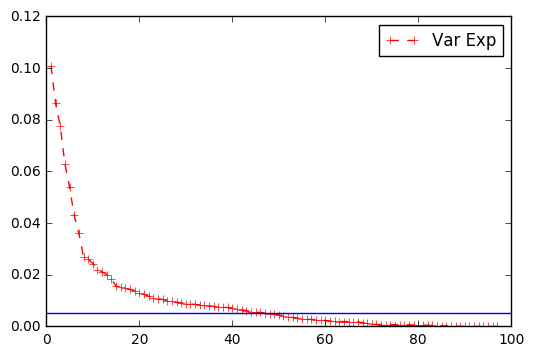

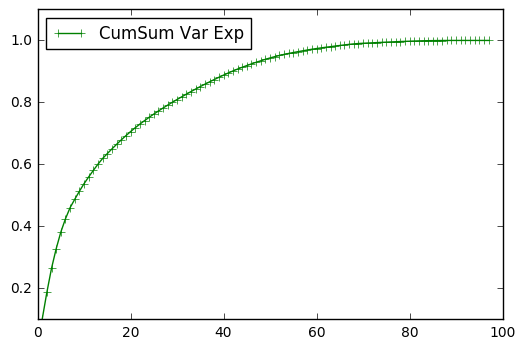

In [14]:
plt.plot(range(1, len(catPCAExpVar)+1), catPCAExpVar, 'r+--', label="Var Exp")
plt.axhline(.05*catPCAExpVar[0])
plt.legend(loc="best")
plt.show()
plt.plot(range(1, len(catPCAExpVarCumSum)+1), catPCAExpVarCumSum, 'g+-', label="CumSum Var Exp")
plt.legend(loc="best")
plt.show()

#### c) document_topics.csv

In [15]:
csvOverview(docTop)

documents_topics.csv
Dataframe has  11325960  rows.
+-----------+--------+------------------+
|document_id|topic_id|  confidence_level|
+-----------+--------+------------------+
|    1595802|     140|0.0731131601068925|
|    1595802|      16|0.0594164867373976|
|    1595802|     143|0.0454207537554526|
|    1595802|     170|0.0388674285182961|
|    1524246|     113| 0.196450402209685|
+-----------+--------+------------------+
only showing top 5 rows



In [16]:
docTopSchema = StructType(
                    [StructField("document_id", StringType(), True),
                     StructField("topic_id", StringType(), True),
                     StructField("confidence_level", DoubleType(), True)])

In [17]:
docTopDF = spark.read.schema(docTopSchema).options(header='true', inferschema='false', nullValue='\\N').csv(docTop)
docTopDF.cache()
print "Number of distinct topics: ", docTopDF.select('topic_id').distinct().count()
print "Number of null values in topic_id: ", docTopDF.where(docTopDF.topic_id.isNull()).count()
print "Number of null values in confidence_level: ", docTopDF.where(docTopDF.confidence_level.isNull()).count()

Number of distinct topics:  300
Number of null values in topic_id:  0
Number of null values in confidence_level:  0


In [18]:
# Converting the docTopDF into a new streched out dataframe by pivoting about the topic_id
docTopPivotDF = docTopDF.groupBy("document_id").pivot("topic_id").agg(F.first("confidence_level")).na.fill(0)
colTopAssembler = VectorAssembler(inputCols=docTopPivotDF.columns[1:], outputCol="allTop")
docTopPivotConcDF = colTopAssembler.transform(docTopPivotDF).select("document_id", "allTop")
docTopPivotConcDF.cache()
docTopPivotConcDF.show(n=5, truncate=False)

+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|document_id|allTop                                                                                                                                                                                                                                                            |
+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|210783     |(300,[17,47,68,77,134,177,180,251],[0.240005019033307,0.0191736882010477,0.0361051803729736,0.0198995300219963,0.00826431857508649,0.020124068804973,0.161245932558863,0

In [19]:
topPCAextracted = PCA(k=300, inputCol = "allTop", outputCol="pca_features")
topPCAmodel = topPCAextracted.fit(docTopPivotConcDF)
topPCAExpVar = topPCAmodel.explainedVariance
topPCAExpVarCumSum = np.cumsum(topPCAExpVar)
%matplotlib inline

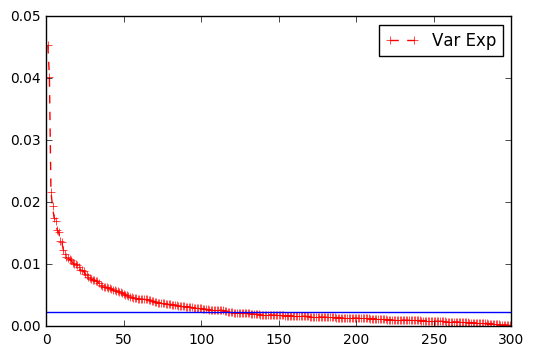

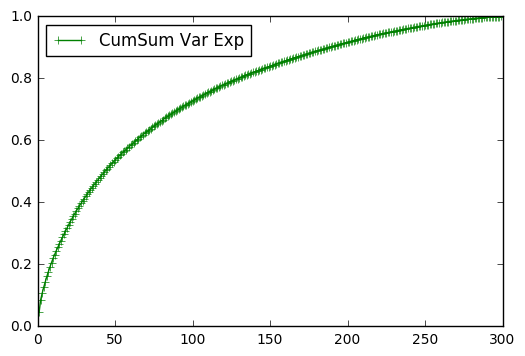

In [20]:
plt.plot(range(1, len(topPCAExpVar)+1), topPCAExpVar, 'r+--', label="Var Exp")
plt.axhline(0.05*topPCAExpVar[0])
plt.legend(loc="best")
plt.show()
plt.plot(range(1, len(topPCAExpVarCumSum)+1), topPCAExpVarCumSum, 'g+-', label="CumSum Var Exp")
plt.legend(loc="best")
plt.show()

### We merge the docTopPivotConcDF and docCatPivotConcDF

In [23]:
docTopCatDF = docTopPivotConcDF.join(docCatPivotConcDF, on="document_id", how="inner")
docTopCatDF.cache()
docTopCatDF.show()
colTopCatAssembler = VectorAssembler(inputCols=["allTop", "allCat"], outputCol="allTopCat")
docTopCatConcDF = colTopCatAssembler.transform(docTopCatDF).select("document_id", "allTopCat")
docTopCatConcDF.cache()
docTopCatConcDF.show()

+-----------+--------------------+--------------------+
|document_id|              allTop|              allCat|
+-----------+--------------------+--------------------+
|     100010|(300,[68,83,104,1...|(97,[39,74],[0.79...|
|    1000240|(300,[44,50,106,1...|(97,[30,32],[0.07...|
|    1000280|(300,[94,111,152,...|(97,[83,86],[0.92...|
|    1000665|(300,[94,229],[0....|(97,[22,78],[0.02...|
|    1000795|(300,[94,229],[0....|(97,[22,78],[0.02...|
|    1000839|(300,[49,90,94,95...|(97,[22,78],[0.05...|
|    1000888|(300,[50,261,273]...|(97,[92,95],[0.92...|
|     100140|(300,[16,92,157],...|(97,[39,40],[0.61...|
|    1001866|(300,[36,55,117,1...|(97,[58,62],[0.07...|
|    1002011|(300,[23,32,43,52...|(97,[64,81],[0.04...|
|    1002185|(300,[92,173,269]...|(97,[39,74],[0.04...|
|     100227|(300,[92,157,168,...|(97,[39,74],[0.05...|
|    1002442|(300,[131,156,171...|(97,[62,64],[0.92...|
|     100263|(300,[61,83,92,26...|(97,[39,45],[0.54...|
|    1002783|(300,[95,229],[0....|(97,[22,81],[0

In [25]:
topcatPCAextracted = PCA(k=397, inputCol = "allTopCat", outputCol="topcat_pca_features")
topcatPCAmodel = topcatPCAextracted.fit(docTopCatConcDF)
topcatPCAExpVar = topcatPCAmodel.explainedVariance
topcatPCAExpVarCumSum = np.cumsum(topcatPCAExpVar)

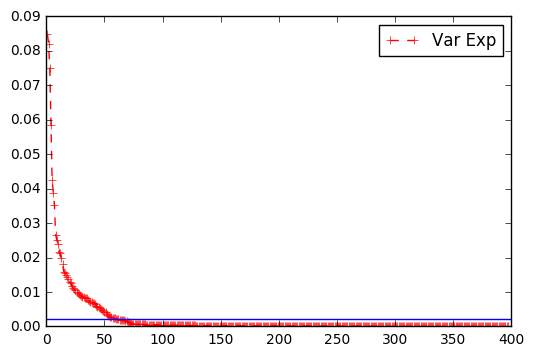

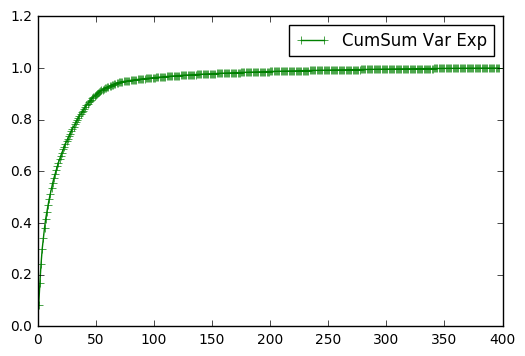

In [26]:
plt.plot(range(1, len(topcatPCAExpVar)+1), topcatPCAExpVar, 'r+--', label="Var Exp")
plt.axhline(0.05*topPCAExpVar[0])
plt.legend(loc="best")
plt.show()
plt.plot(range(1, len(topcatPCAExpVarCumSum)+1), topcatPCAExpVarCumSum, 'g+-', label="CumSum Var Exp")
plt.legend(loc="best")
plt.show()

#### d) document_entities.csv

In [21]:
csvOverview(docEnt)

documents_entities.csv
Dataframe has  5537552  rows.
+-----------+--------------------+-----------------+
|document_id|           entity_id| confidence_level|
+-----------+--------------------+-----------------+
|    1524246|f9eec25663db4cd83...|0.672865314504701|
|    1524246|55ebcfbdaff1d6f60...|0.399113728441297|
|    1524246|839907a972930b17b...|0.392095749652966|
|    1524246|04d8f9a1ad48f126d...|0.213996376305138|
|    1617787|612a1d17685a498af...|0.386192829940441|
+-----------+--------------------+-----------------+
only showing top 5 rows



In [22]:
docEntSchema = StructType(
                    [StructField("document_id", StringType(), True),
                     StructField("entity_id", StringType(), True),
                     StructField("confidence_level", DoubleType(), True)])

In [23]:
docEntDF = spark.read.schema(docEntSchema).options(header='true', inferschema='false', nullValue='\\N').csv(docEnt)
docEntDF.cache()
print "Number of entities entries: ", docEntDF.select('entity_id').count()
print "Number of distinct entities: ", docEntDF.select('entity_id').distinct().count()
print "Number of null values in entity_id: ", docEntDF.where(docEntDF.entity_id.isNull()).count()
print "Number of null values in confidence_level: ", docEntDF.where(docEntDF.confidence_level.isNull()).count()
docEntDF.show(n=10)

Number of entities entries:  5537552
Number of distinct entities:  1326009
Number of null values in entity_id:  0
Number of null values in confidence_level:  0
+-----------+--------------------+-----------------+
|document_id|           entity_id| confidence_level|
+-----------+--------------------+-----------------+
|    1524246|f9eec25663db4cd83...|0.672865314504701|
|    1524246|55ebcfbdaff1d6f60...|0.399113728441297|
|    1524246|839907a972930b17b...|0.392095749652966|
|    1524246|04d8f9a1ad48f126d...|0.213996376305138|
|    1617787|612a1d17685a498af...|0.386192829940441|
|    1617787|fb8c6cb0879e0de87...|0.364116465983032|
|    1617787|793c6a6cf386edb82...|0.349168245516694|
|    1617787|b525b84d5ed52a345...|0.287004519610819|
|    1617787|758cb9cb3014607cb...|0.237956988738312|
|    1617787|d523aaba6d3916f8b...|0.235798527030791|
+-----------+--------------------+-----------------+
only showing top 10 rows



In [24]:
# Converting the docEntDF into a new streched out dataframe by pivoting about the entity_id
#docEntPivotDF = docEntLimitDF.groupBy("document_id").pivot("entity_id").agg(F.first("confidence_level")).na.fill(0)
#colEntAssembler = VectorAssembler(inputCols=docEntPivotDF.columns[1:], outputCol="allEnt")
#docEntPivotConcDF = colEntAssembler.transform(docEntPivotDF).select("document_id", "allEnt")
#docEntPivotConcDF.show(truncate=False)
#sqlContext = SQLContext.getOrCreate(SparkContext.getOrCreate())
#sqlContext.clearCache()

#### Playing around with docEntDF